<img src="https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/hundreds-of-twitter-logos.png"
     width="300000000" />

<h1 style='font-family: Source Sans Pro'>Cyberbullying Detection EDA | AutoML | DL | BERT</h1>

This is a subtle attempt at learning the basics of NLP, Text analysis, experimenting with DL models and State of the art attention models like BERT. We start with an in depth analysis of the tweets that we have, preprocess them and go forward with the modelling process.

We have multiple datasets containing data from multiple sources like youtube, twitter, kaggle, etc. Every dataset will have seperate preprocessing steps. We're going with the `twitter_parsed_dataset` for the sake of simplicity.
Throughout the notebook, I'll try to take you through my though process as a beginner in NLP. I'll dive into all the challenges I faced and solutions found. lets begin!!

<h2 style='font-family: Source Sans Pro'>Table of contents</h2>

[Importing the necessary libraries ](#a1)<br>
[Basic preprocessing and sample tweets](#a2)

* [🕵🏻 Exploratory Data Analysis](#chapter1)
    * [Sentiment analysis](#section_1_1)
    * [Analysis of common hashtags and mentions](#section_1_2)
    * [☁️ Wordclouds for toxic text](#section_1_3)


* [👾 Modelling](#chapter2)
    * [ML approach with word2vec](#section_2_1)
        * [Pycaret's AutoML](#section_2_1_1)
    * [🧠 Deep learning models](#section_2_2)
        * [♾️ Simple RNNs with trainable embeddings](#section_2_2_1)
        * [🌐 LSTM with GloVe embeddings](#section_2_2_2)
        * [GRUs with trainable embeddings](#section_2_2_3)
    * [⬅️➡️ BERT with Tensorflow Hub](#section_2_3)
        * [How to use a tf hub BERT model](#section_2_3_1)




### 🔵 Installing and importing libraries <a class="anchor"  id="a1"></a>

In [ ]:
## Install necessary libraries

! pip install -Uqqq seaborn
! pip install -Uqqq squarify
! pip install -Uqqq nltk
! pip install -Uqqq wordcloud
! pip install -Uqqq spacy
! pip install -Uqqq imblearn
! pip install -Uqqq gensim
!python -m spacy download en_core_web_sm

In [1]:
## Importing the necessary libraries 

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
import squarify
from tqdm import tqdm

import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import tensorflow as tf
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.13.0
REPLICAS:  1


In [15]:
## Helper functions

def add_spines(colour = '#425169', linewidth = 2):
    """
    Add beautiful spines to you plots
    """
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines[['bottom', 'left', 'top', 'right']].set_color(colour)
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(linewidth)

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

### 🔵 Basic preprocessing and sample tweets <a class="anchor"  id="a2"></a>

In [3]:
df = pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# analysis of mentions and tweets

# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
    hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
    return hashtag_count, mention_count

# Apply the function to each row in the 'text' column
df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))

print('\nDataset shape: ', df.shape)
df.head()


Dataset shape:  (16848, 5)


,Text,Annotation,Label,num_hashtags,num_mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1
4,#mkr No No No No No No,none,0.0,1,0


In [4]:
print('_________Sample tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n_______________________________')

_________Sample tweets_________

Simple tweet:  @ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.


Sexist tweet:  RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy


Racist tweet:  @g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.

_______________________________


# 🕵🏻 Exploratory Data Analysis <a class="anchor"  id="chapter1"></a>

>We analyse different aspects of the twitter dataset here. We start with simple tasks like understanding the label and Annotation distribution, and slowly progress toward extracting and analysing #hastags, @mentions and finally generate wordclouds of high frequency words according to annotations. 

In [7]:
## Basic analysis of labels and annotations

print('Label distribution')
print(df.Label.value_counts())
print('-------------------------\n')
print('Annotation distribution')
print(df.Annotation.value_counts())
print('-------------------------\n')
print('Grouping of Annotation with label')
print(df.groupby('Annotation')['Label'].sum())

Label distribution
Label
0.0    11501
1.0     5347
Name: count, dtype: int64
-------------------------

Annotation distribution
Annotation
none      11501
sexism     3377
racism     1970
Name: count, dtype: int64
-------------------------

Grouping of Annotation with label
Annotation
none         0.0
racism    1970.0
sexism    3377.0
Name: Label, dtype: float64


As you can see the text with annotations of anything other than none are all classified as toxic. Hence, it would be a dead giveaway to include it in our dataset. We may try to classify the text with the annotations later
___

#### Highlighting columns in your seaborn plots<br>
This is just a fun way in which you can highlight certain bars in your barplot. We create a specific function that returns a palette of length equal to the unique categories in the column you're plotting and specifically highlights the indexes passed to it.

In [8]:
def bully_palette(df,column, positions_to_change: list):
    """
    A function to create grey red palettes according to the inputs
    You just need to pass in the dataframe and the index of labels to be highlighted in red
    """
    palette = ['#96898b']*df[column].nunique()
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)
    
# example
# bully_palette(df,'Label', [0, 1])

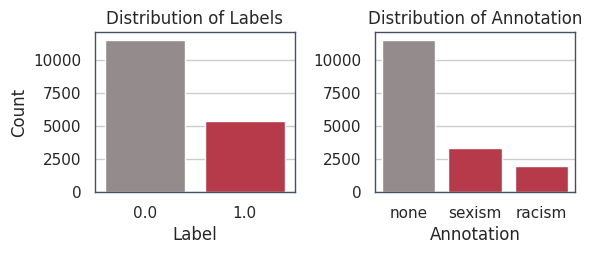

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
# using the bully_pallete function to create a custom pallete
sns.countplot(x='Label', data=df, palette = bully_palette(df, 'Label', [1]))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
# adding spines using the helper function we declared earlier
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='Annotation', data=df, palette = bully_palette(df,'Annotation', [1, 2]))
plt.xlabel('Annotation')
plt.ylabel('')
plt.title('Distribution of Annotation')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
plt.show()

This is how our highlighted plots turned out. Do play around with these... highlight with your own colours... add functionalities etc.<br><br>
We can see that the lable `1` has further been divided into the categories `sexism` and `racism`. Sexism is more prevelant than racism. Racism is looked upon more harshly by the public or twitter might be efficient at removing racist tweets from their site (we never know🤷‍♀️).

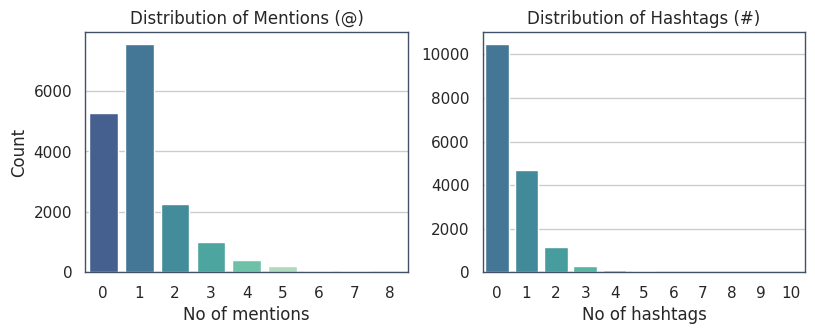

In [10]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=df, palette =  sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions')
plt.ylabel('Count')
plt.title('Distribution of Mentions (@)')
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=df, palette = sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)
plt.show()

<Figure size 600x300 with 0 Axes>

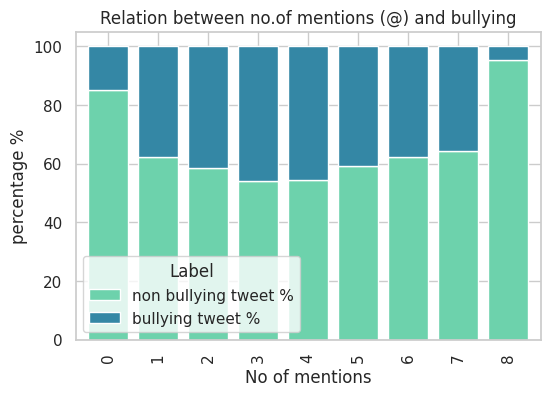

In [11]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(df['num_mentions'], df['Label'])
mention_label_cross['sum'] = mention_label_cross[0.0] + mention_label_cross[1.0]
mention_label_cross['non bullying tweet %'] = mention_label_cross[0.0]/mention_label_cross['sum']*100
mention_label_cross['bullying tweet %'] = mention_label_cross[1.0]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and bullying')
plt.show()

> Here you can see that as the mentions increase to 4, the percentage of bullying tweets increases compared to the normal ones. But the trend once again reverses as the mentions increase upto 8. No clear pattern was seen between number of hashtags and percentage of bullying tweets

### Sentiment analysis
Here I planned on checking whether the sentiment of the tweets directly correlate with bullying. ie. more  negativity a tweet contains, higher the probability of bullying. Turns out it wasn't as straightforward as that. The dataset contains a lot of negative tweets... which is a good thing since our models should be able to understand the difference between a `negative` tweet and a `bullying` tweet. It shouldn't flag every other negative tweet as bullying.

In [12]:
## Using the nltk library to analyze sentiment of each text so that we can correlate it with bullying
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'


df['Sentiment_Label'] = df['Text'].apply(get_sentiment)

df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3,negative
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1,negative
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1,positive
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1,negative
4,#mkr No No No No No No,none,0.0,1,0,negative


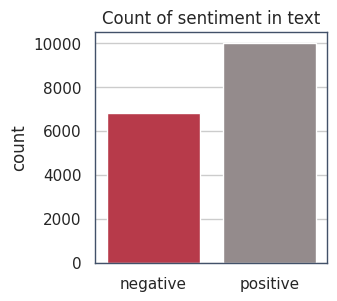

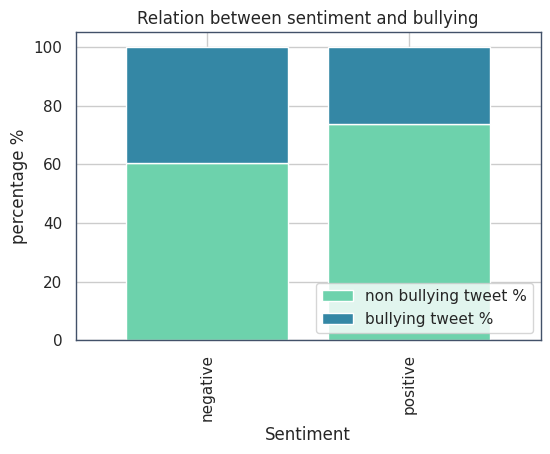

In [13]:
plt.figure(figsize=(3, 3))
df['Sentiment_Label'].value_counts()
sns.countplot(x='Sentiment_Label', data=df, palette = bully_palette(df, 'Sentiment_Label', [0]))
plt.title('Count of sentiment in text')
plt.xlabel('')
add_spines(linewidth=1)

sent_label_cross = pd.crosstab(df['Sentiment_Label'], df['Label'])
sent_label_cross['sum'] = sent_label_cross[0.0] + sent_label_cross[1.0]
sent_label_cross['non bullying tweet %'] = sent_label_cross[0.0]/sent_label_cross['sum']*100
sent_label_cross['bullying tweet %'] = sent_label_cross[1.0]/sent_label_cross['sum']*100
sent_label_cross = sent_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

ax = sent_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('percentage %')
plt.title('Relation between sentiment and bullying')
ax.legend(loc='lower right')
add_spines(linewidth=1)

plt.show()

<div class="alert alert-block alert-success">
<b>💡Idea:</b> We could add either the sentiment score or the label as a feature to train our models. Though I haven't actually done that... it may be a great idea for you guys to try out!!

### Analysis of common hashtags and mentions

The tweets contain a bunch of hashtags and mentions. What kind of twitter analysis would this be if we leave these out :P  Analysing this part made me have questions over the quality of the dataset. Let's understand why...
- The tweets seems to be majorly sourced from particular feeds or are retweets to particular user.
- A majority of the tweets feature the TV show `My kitchen rules`. 

#### A very key takeaway: 
The data collector was an australian interested in cooking👨‍🍳😆 

In [14]:
## Extraction of the top ten mentions and hashtags in the dataset

# Function to extract hashtags from a text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)

# Function to extract hashtags from a text
def extract_mentions(text):
    return re.findall(r'@\w+', text)

df['Mentions'] = df['Text'].apply(extract_mentions)

def create_counter_df(df):
    """
    Creates a dataframe that contains the Label and their count.
    Pass the dataframe containing the labels in the form of a list column as an input.
    Example usage:
    1. mentions = create_counter_df(df['Mentions'])
    2. sexist_mentions = create_counter_df(df[df.Annotation=='sexist']["Mentions"])
    """
    # Flatten the list of hashtags and count their occurrences
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)

    # Create a DataFrame from the Counter dictionary
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df
    
mentions_df = create_counter_df(df['Mentions'])
top_10_mentions = mentions_df.head(10)
sexist_mentions = create_counter_df(df[df.Annotation=='sexism']["Mentions"])
top_10_sexist_mentions = sexist_mentions.head(10)
racist_mentions = create_counter_df(df[df.Annotation=='racism']["Mentions"])
top_10_racist_mentions = racist_mentions.head(10)

hashtags_df = create_counter_df(df['Hashtags'])
top_10_hashtags = hashtags_df.head(10)
sexist_hashtags = create_counter_df(df[df.Annotation=='sexism']["Hashtags"])
top_10_sexist_hashtags = sexist_hashtags.head(10)
racist_hashtags = create_counter_df(df[df.Annotation=='racism']["Hashtags"])
top_10_racist_hashtags = racist_hashtags.head(10)

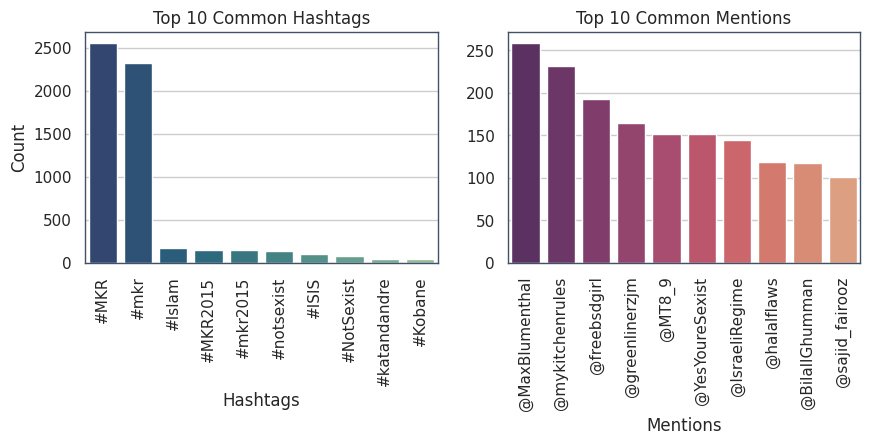

In [15]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.barplot(x='Label', y='Count', data=top_10_hashtags, palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(122)
sns.barplot(x='Label', y='Count', data=top_10_mentions, palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

<img src="https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/twitter_%23%40.png"
     width="300000000" />
     
`#MKR` (@mykitchenrules) is the most popular hashtag in the dataset whereas `@MaxBlumenthal` is the most popular mention.



I did some digging around `@MaxBlumenthal` and found this:

#### Who he is:
- American author and blogger: Born in 1977, Blumenthal has written for publications like The Nation, The New York Times, and The Daily Beast. He currently edits The Grayzone website.
- Investigative journalist: Blumenthal's work focuses on politics, media, and human rights, often with a critical view of US foreign policy and the Israeli-Palestinian conflict.
- Author: He's written several books, including "Republican Gomorrah" and "Goliath: Life and Loathing in Greater Israel," which won awards and ignited debate.

#### Controversies:
- The Grayzone: Some see The Grayzone as promoting conspiracy theories and Russian propaganda, particularly regarding the Syrian Civil War. Blumenthal maintains editorial independence and focuses on investigative journalism.
- Methodology: Critics question Blumenthal's use of anonymous sources and selective evidence, while supporters defend his investigative techniques and access to information denied to mainstream media.

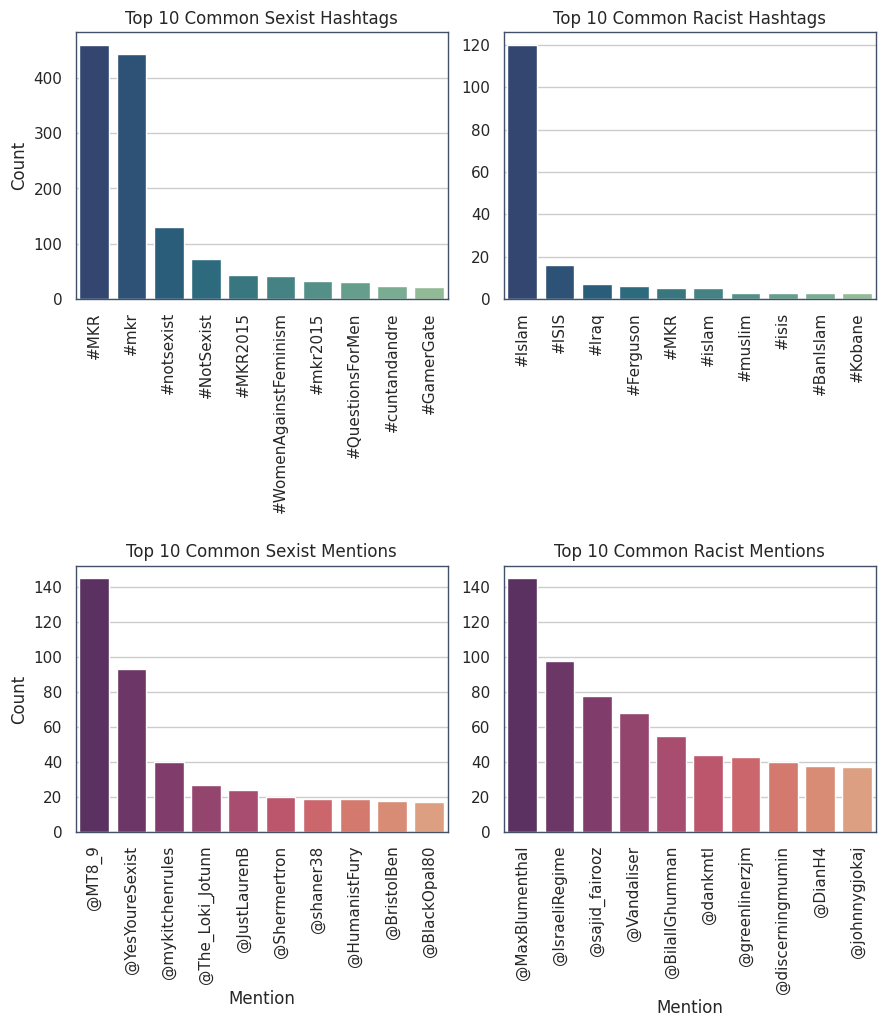

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.barplot(x='Label', y='Count', data=top_10_sexist_hashtags, palette='crest_r')
plt.title('Top 10 Common Sexist Hashtags')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(222)
sns.barplot(x='Label', y='Count', data=top_10_racist_hashtags, palette='crest_r')
plt.title('Top 10 Common Racist Hashtags')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(223)
sns.barplot(x='Label', y='Count', data=top_10_sexist_mentions, palette='flare_r')
plt.title('Top 10 Common Sexist Mentions')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(224)
sns.barplot(x='Label', y='Count', data=top_10_racist_mentions, palette='flare_r')
plt.title('Top 10 Common Racist Mentions')
plt.xlabel('Mention')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=1)
plt.show()

#### Key takeaways from the most common @ and #s

- For some reason `#MKR` and `#mkr` (my kitchen rules) feature on the top of the sexist hashtags. Maybe coz its a cooking show. lol. It might be due to the fact that #MKR is the most common hashtag on the dataset. <br>
- You can see religiously motived terrorist groups like `#isis` feature on the most common racist hashtags <br>
- `@YesYoureSexist` sounds like a provocative username. No wonder it has the second most sexist mentions 
- `@MaxBlumenthal` a controversial American author and blogger features on the top of Racist mentions

### Preprocessing the text 

In [17]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tweet_tokens = nltk.word_tokenize(tweet)
#     tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])
    
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

In [18]:
df['Text'] = df['Text'].apply(clean_tweet)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label,Hashtags,Mentions
0,I read they in contextno change in mean th...,none,0.0,0,3,negative,[],"[@halalflaws, @biebervalue, @greenlinerzjm]"
1,now you idiot claim that people who try to s...,none,0.0,0,1,negative,[],[@ShreyaBafna3]
2,call I sexist but when I go to an auto plac...,sexism,1.0,0,1,positive,[],[@Mooseoftorment]
3,wrong isis follow the example of mohammed an...,racism,1.0,0,1,negative,[],[@g0ssipsquirrelx]
4,no no no no no no,none,0.0,1,0,negative,[#mkr],[]


In [19]:
print('_________Sample clean tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\n\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n\n_______________________________')

_________Sample clean tweets_________


Simple tweet:    now you idiot claim that people who try to stop he from become a terrorist make he a terrorist islamically brain dead


Sexist tweet:     call I sexist but when I go to an auto place i d rather talk to a guy


Racist tweet:    wrong isis follow the example of mohammed and the quran exactly


_______________________________


### ☁️ Wordclouds for toxic text <a class="anchor"  id="section_1_3"></a>

We are using a popular method of plotting wordclouds in the shapes of masks created out of png images. Lets say you want to create a wordcloud for text related to sexism...
1. Simply google search for an image like 'sexism logo png'
2. Choose an image of your choice, left click on it and open it in a new tab <br>
3. Copy the url and paste it in the code hidden below

For a detailed look at how to do this.. check out this notebook: [Spooky NLP and Topic Modelling tutorial](https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial/notebook) <br>
This notebook uses the Base64 encoding of images to create the wordclouds while you can straightaway use the URL of the images as I have done below
Viola!! there you have it. Beautiful wordclouds with meanings represented in the form of shapes. The hidden code cell below explains all the steps.

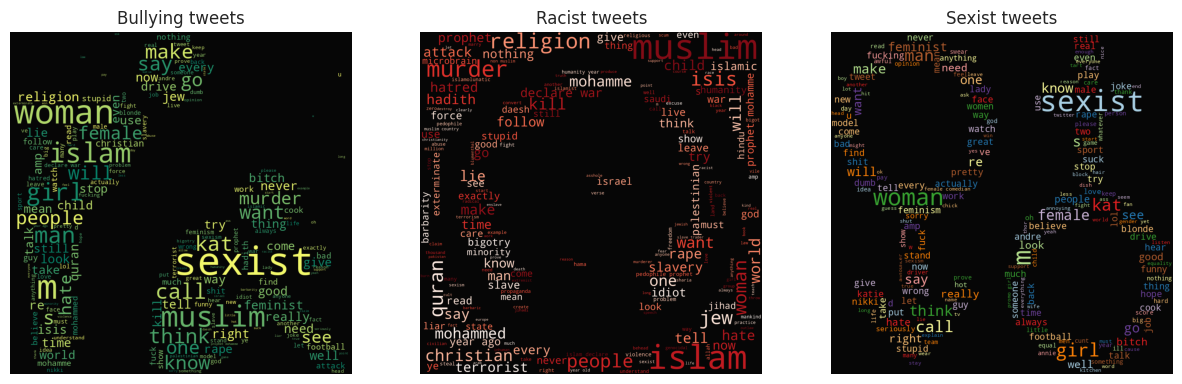

In [20]:
stopword=set(STOPWORDS)
plt.figure(figsize=(15,40))

## Common words in all bullying tweets-----------------------------------------------------------------------------------
plt.subplot(131)
# 1. Get text
bully_text = df[df.Label==1.0]["Text"].values
Text = ''
for text in bully_text:
    Text += text

# 2. Load png image from url and create mask
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/bullying-computer-icons-harassment-clip-art-bully.jpg'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

# 3. Plot wordcloud
wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Bullying tweets')
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)


## Common words in all racist tweets-----------------------------------------------------------------------------------
# Repeat for other plots
plt.subplot(132)
bully_text = df[df.Annotation=='racism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://clipart-library.com/img1/1475559.png'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.title('Racist tweets')
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)


## Common words in all sexist tweets-----------------------------------------------------------------------------------
plt.subplot(133)
bully_text = df[df.Annotation=='sexism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/woman-gender-symbol-male-female-text-line-circle-number-png-clipart.jpg'
response.raise_for_status()
response = requests.get(image_url, stream=True)
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Sexist tweets')
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

# 👾 Modelling <a class="anchor"  id="chapter2"></a>

### Preprocessing for modelling
Most of these steps have been covered earlier. You may expand this section to view the rest of the changes I made to the dataset

In [2]:
# ignore this. I did this for ease of processing when i restart the kernel
# this part gives you the completely preprocessed data right to the point where you just need to oversample and split it

df = pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# Adding hashtags and mentions_____________________________________________________________________________________# 
# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
#     hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
#     return hashtag_count, mention_count
    return mention_count

# Apply the function to each row in the 'text' column
df[['num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))
# df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))


# Analyze sentiment of each text____________________________________________________________________________________# 
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'

# Apply the function to each row in the 'Text' column
df['Sentiment_Label'] = df['Text'].apply(get_sentiment)


# Cleaning the tweets_________________________________________________________________________________________________# 
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
      
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

df['Text'] = df['Text'].apply(clean_tweet)
#____________________________________________________________________________________________________________________# 

# One hot encoding of the sentiment category
one_hot_encoded = pd.get_dummies(df['Sentiment_Label'], prefix='sentiment')
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop('Sentiment_Label', axis=1)
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['Text'] = df['Text'].str.strip()

# Step 2: Upsample the data using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

In [3]:
# Step 2: Oversample the data using RandomOverSampler to reduce imbalance between Labels (Bullying and non bullying)
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

## ML approach with word2vec <a class="anchor"  id="section_2_1"></a>
#### Why use Word2Vec?
- Semantic understanding: Word2Vec captures the semantic relationships between words, which is crucial for understanding the nuances of language used in bullying. It can differentiate between words with similar spellings but different meanings (e.g., "joke" vs. "mock") and identify synonyms and antonyms, helping to detect subtle insults and sarcasm often employed in cyberbullying.

- Handling slang and abbreviations: Twitter language is full of slang, abbreviations, and emojis. Word2Vec can learn these informal and often-evolving expressions, leading to more accurate detection of bullying even when it doesn't use traditional language patterns.


#### Limitations of using Word2Vec
- Bias: Word2Vec models can inherit biases from the training data, potentially leading to discriminatory outcomes. Careful selection of training data and evaluation methods are crucial.
- Context sensitivity: Subtle forms of bullying often rely on context not captured solely by word meaning. Combining Word2Vec with other approaches that consider context can improve accuracy.

For detailed explaination of the intuition behind W2V read: [Word2Vec Explained](https://archive.is/4lJS5)

In [5]:
# Train Word2Vec Model
sentences = [word_tokenize(text) for text in X_resampled]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # Adjust parameters as needed

# Convert Text to Embeddings
def get_embedding(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
    if len(tokens) > 0:
        # Return the average of word embeddings for the tokens
        return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
    else:
        return None

# Create an array of embeddings for each text
X_resampled = [get_embedding(text) for text in X_resampled]

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Model Training (Using a RandomForestClassifier as an example)
X_train = np.array(X_train)
X_test = np.array(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.8867637470115193
F1 Score: 0.8832623795653148


# Pycaret's AutoML <a class="anchor"  id="section_2_1_1"></a>

In [ ]:
# !pip install -Uqqq pycaret==3.1.0
# from pycaret.classification import *

# Train-Test Split: ensure you are using the word2vec processed data from the above section
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# create a dataset using X_train and y_train
columns = []
dataset = np.column_stack((X_train, y_train))
for i in range(300):
    columns.append(str(i))
columns.append('Label')
auto_df = pd.DataFrame(dataset, columns=columns)

auto_df.head()

In [16]:
pycaret_automl = setup(data=auto_df, target = 'Label', session_id=42)

,Description,Value
0,Session id,42
1,Target,Label
2,Target type,Binary
3,Original data shape,"(18401, 301)"
4,Transformed data shape,"(18401, 301)"
5,Transformed train set shape,"(12880, 301)"
6,Transformed test set shape,"(5521, 301)"
7,Numeric features,300
8,Preprocess,True
9,Imputation type,simple


In [17]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8384,0.8997,0.7795,0.8855,0.8290,0.6769,0.6820,2.2820
rf,Random Forest Classifier,0.8349,0.8950,0.8002,0.8618,0.8297,0.6698,0.6718,8.9130
xgboost,Extreme Gradient Boosting,0.8144,0.8774,0.8116,0.8182,0.8148,0.6289,0.6290,4.9650
catboost,CatBoost Classifier,0.7899,0.8599,0.7477,0.8191,0.7816,0.5800,0.5824,54.2000
qda,Quadratic Discriminant Analysis,0.7870,0.8520,0.7582,0.8067,0.7816,0.5742,0.5754,0.3320
lightgbm,Light Gradient Boosting Machine,0.7843,0.8561,0.7486,0.8085,0.7773,0.5688,0.5705,9.2390
dt,Decision Tree Classifier,0.7567,0.7567,0.8125,0.7328,0.7705,0.5130,0.5163,2.6700
lda,Linear Discriminant Analysis,0.7460,0.8164,0.7038,0.7712,0.7358,0.4923,0.4944,0.5210
gbc,Gradient Boosting Classifier,0.7288,0.8040,0.6373,0.7829,0.7025,0.4582,0.4665,51.5740
ridge,Ridge Classifier,0.7139,0.0000,0.6506,0.7477,0.6956,0.4282,0.4320,0.1100


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

## 🧠 Deep learning models <a class="anchor"  id="section_2_2"></a>

In [4]:
# using the cleaned version of the dataset
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [5]:
# using keras tokenizer to find the length vocab 
token = text.Tokenizer(num_words=None)
max_len = 40

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [6]:
print('Preprocessed text', X_train[1])
print('\nTokenized text', xtrain_seq[1])
print('\nPadded text', xtrain_pad[1])
print('\nPadded text Length: ', len(xtrain_pad[1]))

Preprocessed text I m not sexist but girl should not wrestle

Tokenized text [3, 18, 4, 19, 14, 45, 71, 4, 2156]

Padded text [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    3   18    4   19   14   45   71    4 2156]

Padded text Length:  40


In [7]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [03:44, 9776.98it/s] 

Found 2196017 word vectors.


In [8]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 12670/12670 [00:00<00:00, 234339.32it/s]


# ♾️ Simple RNNs with trainable embeddings <a class="anchor"  id="section_2_2_1"></a>

In [12]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           3801300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 3841501 (14.65 MB)
Trainable params: 3841501 (14.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: user 317 ms, sys: 306 ms, total: 623 ms
Wall time: 788 ms


In [13]:
model.fit(xtrain_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

Epoch 1/5
288/288 [==============================] - 33s 105ms/step - loss: 0.4928 - accuracy: 0.7564
Epoch 2/5
288/288 [==============================] - 11s 38ms/step - loss: 0.1742 - accuracy: 0.9371
Epoch 3/5
288/288 [==============================] - 12s 43ms/step - loss: 0.0743 - accuracy: 0.9765
Epoch 4/5
288/288 [==============================] - 11s 38ms/step - loss: 0.0469 - accuracy: 0.9870
Epoch 5/5
288/288 [==============================] - 10s 35ms/step - loss: 0.0401 - accuracy: 0.9889


In [16]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,y_test)))

144/144 [==============================] - 1s 4ms/step
Auc: 0.93%


# 🌐 LSTM with GloVe embeddings <a class="anchor"  id="section_2_2_2"></a>


#### Advantages of GloVe Embeddings:
- Global Matrix Factorization: GloVe considers global word-word co-occurrence statistics, capturing broader semantic relationships and potentially enhancing bullying detection accuracy.
- Efficient Training: GloVe's training algorithm is computationally efficient, allowing for analysis of large tweet datasets more easily.

#### Limitations of GloVe Embeddings
- Bias: As with any word embedding model, GloVe can inherit biases from training data. Careful selection and evaluation are crucial to mitigate discriminatory outcomes.
- Context Sensitivity: While GloVe captures global semantic relationships, it may miss subtle nuances that rely heavily on context. Combining it with context-aware techniques is recommended for optimal results.

For detailed explaination of the intuition behind GloVe read: [NLP — Word Embedding & GloVe](https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6)

In [17]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100))
    # dropout=0.3, recurrent_dropout=0.3
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 300)           3801300   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3961801 (15.11 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 3801300 (14.50 MB)
_________________________________________________________________
CPU times: user 319 ms, sys: 27.1 ms, total: 346 ms
Wall time: 349 ms


In [18]:
model.fit(xtrain_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
288/288 [==============================] - 4s 5ms/step - loss: 0.4987 - accuracy: 0.7697
Epoch 2/5
288/288 [==============================] - 1s 5ms/step - loss: 0.4242 - accuracy: 0.8069
Epoch 3/5
288/288 [==============================] - 1s 5ms/step - loss: 0.3793 - accuracy: 0.8337
Epoch 4/5
288/288 [==============================] - 1s 5ms/step - loss: 0.3237 - accuracy: 0.8636
Epoch 5/5
288/288 [==============================] - 1s 5ms/step - loss: 0.2663 - accuracy: 0.8936


In [19]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,y_test)))

144/144 [==============================] - 1s 2ms/step
Auc: 0.92%


# GRUs with trainable embeddings <a class="anchor"  id="section_2_2_3"></a>

In [20]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(300))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 300)           3801300   
                                                                 
 spatial_dropout1d (Spatial  (None, 40, 300)           0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 4343401 (16.57 MB)
Trainable params: 4343401 (16.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: user 277 ms, sys: 9.15 ms, total: 286 ms
Wall time: 280 ms


In [21]:
model.fit(xtrain_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
288/288 [==============================] - 20s 61ms/step - loss: 0.4864 - accuracy: 0.7660
Epoch 2/5
288/288 [==============================] - 3s 12ms/step - loss: 0.2921 - accuracy: 0.8833
Epoch 3/5
288/288 [==============================] - 4s 13ms/step - loss: 0.1950 - accuracy: 0.9269
Epoch 4/5
288/288 [==============================] - 3s 11ms/step - loss: 0.1355 - accuracy: 0.9495
Epoch 5/5
288/288 [==============================] - 4s 14ms/step - loss: 0.1002 - accuracy: 0.9651


In [22]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,y_test)))

144/144 [==============================] - 1s 2ms/step
Auc: 0.92%


<div class="alert alert-block alert-info">
<b>Note:</b>
We can see that trainable embeddings perform better than GloVe embeddings on our task. GloVe embeddings do a good job of providing us with global embeddings. These embeddings are not contextually aware and hence are not well suited for complex tasks. eg. The word 'date' may have different meanings depending on the context.

# ⬅️➡️ BERT with Tensorflow Hub <a class="anchor"  id="section_2_3"></a>

In [23]:
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [24]:
# creating tensorflow datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test))

BUFFER_SIZE = 4000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
print("Train dataset element spec:", train_dataset.element_spec)
print("Test dataset element spec:", test_dataset.element_spec)

Train dataset element spec: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))
Test dataset element spec: TensorSpec(shape=(None,), dtype=tf.string, name=None)


In [26]:
for example, label in train_dataset.take(1): # take returns a batch of train_dataset, containing 64 feature, label pairs.
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'why do you complain islam have be ethnic cleansing everybody for year be not it time to return the favor'
 b'remind I of simpson where grandpa be scream death at everything now its rape'
 b'because christianity be die out and the christian world have reform itself']

labels:  [1. 1. 1.]


### How to use a tf hub BERT model <a class="anchor"  id="section_2_3_1"></a>
To use and train a BERT model from tensorflow hub, you simply need the links from where the model will be downloaded and trained. <br>
Every BERT model requires a BERT preprocess model that takes care of all the preprocessing required to input data in to BERT. 

In [27]:
# loading the preprocessing and main model from tf hub links

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Here we take some sample input texts and test the bert preprocess model on them. We analyze the outputs given by the model below

In [28]:
# Testing the bert preprocessor

text_test = ["Today's weather is harsh", "My name is harsh"]
text_preprocessed = bert_preprocess_model(text_test)

for i in range(len(text_test)):
    print('Input text :', text_test[i])
    print(f'Keys       : {list(text_preprocessed.keys())}')
    print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
    print(f'Word Ids   : {text_preprocessed["input_word_ids"][i, :12]}')
    print(f'Input Mask : {text_preprocessed["input_mask"][i, :12]}')
    print(f'Type Ids   : {text_preprocessed["input_type_ids"][i, :12]}')
    print('\n')
# input_type_ids has the same shape as input_mask, but inside the non-padded region,
# contains a 0 or a 1 indicating which sentence the token is a part of.

# context is not being mapped at the preprocessing layer
# The word 'Harsh' will have the same token no matter what the scenario
# BERT will perform the contextualization when the text is passed through it

Input text : Today's weather is harsh
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [ 101 2651 1005 1055 4633 2003 8401  102    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Input text : My name is harsh
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [ 101 2026 2171 2003 8401  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]




In [29]:
# Model link: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Encoder Outputs Shape:{bert_results["encoder_outputs"][0].shape}')
# print(f'Encoder Outputs Values:{bert_results["encoder_outputs"][0][0, :3]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :3]}')

# BERT takes our sentence and outputs a 768 token pooled representation, where every word is mapped in a 128 dimension array

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2
Keys       : ['sequence_output', 'pooled_output', 'encoder_outputs', 'default']
Pooled Outputs Shape:(2, 256)
Pooled Outputs Values:[-0.93483615  0.17718004 -0.99869305 -0.4218715   0.11775441  0.98258984
 -0.16275282 -0.04727218 -0.06515574  0.9153972   0.02720805  0.9951548 ]
Encoder Outputs Shape:(2, 128, 256)
Sequence Outputs Shape:(2, 128, 256)


- The pooled outputs provide a fixed-size representation of the entire input sequence,
- The encoder outputs represent the contextualized embeddings of each token, and the sequence
- Outputs retain token-level information for more detailed analysis or tasks.
- Either of those can be used as input to further model building depending on granularity of the task

In [30]:
# A function that takes in the links for the model and returns a newly compiled model

def create_model(model_link, preprocess_link):
  # bert_model = hub.KerasLayer(model_link)
  # bert_preprocess_model = hub.KerasLayer(preprcess_link)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocess_link, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(model_link, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    model = tf.keras.Model(text_input, net)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                              loss=loss,
                              metrics=metrics)
    return model

In [31]:
DATA_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()

print("Size of the dataset:", DATA_SIZE)
BATCH_SIZE = 16
STEPS_PER_EPOCH = DATA_SIZE // BATCH_SIZE

Size of the dataset: 288


In [32]:
# bert_en_uncased_L-4_H-256_A-4/2

with strategy.scope():
    model = create_model('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2', 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
model.fit(train_dataset, epochs=10, batch_size=16)
# directly passed in the train_dataset tensor to the model as the preprocessing layer takes care of embedding

Epoch 1/10
288/288 [==============================] - 95s 279ms/step - loss: 0.5043 - binary_accuracy: 0.7551
Epoch 2/10
288/288 [==============================] - 65s 226ms/step - loss: 0.3725 - binary_accuracy: 0.8364
Epoch 3/10
288/288 [==============================] - 64s 222ms/step - loss: 0.2749 - binary_accuracy: 0.8894
Epoch 4/10
288/288 [==============================] - 63s 217ms/step - loss: 0.2053 - binary_accuracy: 0.9195
Epoch 5/10
288/288 [==============================] - 63s 217ms/step - loss: 0.1592 - binary_accuracy: 0.9397
Epoch 6/10
288/288 [==============================] - 62s 215ms/step - loss: 0.1218 - binary_accuracy: 0.9563
Epoch 7/10
288/288 [==============================] - 62s 217ms/step - loss: 0.0962 - binary_accuracy: 0.9638
Epoch 8/10
288/288 [==============================] - 63s 219ms/step - loss: 0.0829 - binary_accuracy: 0.9688
Epoch 9/10
288/288 [==============================] - 63s 219ms/step - loss: 0.0705 - binary_accuracy: 0.9740
Epoch 10/1

In [33]:
# since the model is showing continued improvements let us train it some more
model.fit(train_dataset, epochs=5, batch_size=16)

Epoch 1/5
288/288 [==============================] - 63s 218ms/step - loss: 0.0537 - binary_accuracy: 0.9804
Epoch 2/5
288/288 [==============================] - 63s 220ms/step - loss: 0.0477 - binary_accuracy: 0.9819
Epoch 3/5
288/288 [==============================] - 63s 218ms/step - loss: 0.0460 - binary_accuracy: 0.9823
Epoch 4/5
288/288 [==============================] - 63s 220ms/step - loss: 0.0408 - binary_accuracy: 0.9858
Epoch 5/5
288/288 [==============================] - 63s 219ms/step - loss: 0.0373 - binary_accuracy: 0.9861


Now that we've achieved respectable results using BERT, let us save the model locally for future inference.

In [34]:
model_path = '/kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2'
model.save(model_path, include_optimizer=True)

In [35]:
# reload
reloaded_model = tf.saved_model.load(model_path)

In [36]:
# infer
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'Your mom is a fucking whore',
    'You are beautiful',
    'suck my dick you fucking bitch',
    'all muslims are terrorists',
    'Women are terrible drivers'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: Your mom is a fucking whore    : score: 0.996543
input: You are beautiful              : score: 0.876642
input: suck my dick you fucking bitch : score: 0.999874
input: all muslims are terrorists     : score: 0.988921
input: Women are terrible drivers     : score: 0.695643



<div class="alert alert-block alert-success">
You can see that all the tweets except the second one get a high score. Showing that our model is doing good.

In [37]:
# lets download the file from our kaggle working directory

# You can use !zip -r filename.zip directory_path command to zip the directory.
!zip -r twitter_smallbert_en_uncased_L-4_H-256_A-4.zip /kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4

from IPython.display import FileLink
FileLink(r'/kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4.zip')

  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/ (stored 0%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/ (stored 0%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/keras_metadata.pb (deflated 83%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/saved_model.pb (deflated 91%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/assets/ (stored 0%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/assets/vocab.txt (deflated 53%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/fingerprint.pb (stored 0%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/variables/ (stored 0%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/variables/variables.data-00000-of-00001 (deflated 38%)
  adding: kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4/2/variables/variables.index (deflated 76%)


/kaggle/working/twitter_smallbert_en_uncased_L-4_H-256_A-4.zip